In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from scipy.stats import poisson
from scipy.stats import binom

data = pd.read_csv('driverAcceptanceData.csv')
data.head()

,PAY,ACCEPTED
0,29.358732,0
1,22.986847,0
2,18.020348,0
3,45.730717,1
4,14.642845,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAY       1000 non-null   float64
 1   ACCEPTED  1000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


In [3]:
data.describe()

,PAY,ACCEPTED
count,1000.000000,1000.00000
mean,25.713530,0.52700
std,10.051410,0.49952
min,0.000000,0.00000
25%,18.878792,0.00000
50%,25.483059,1.00000
75%,32.825641,1.00000
max,53.667563,1.00000


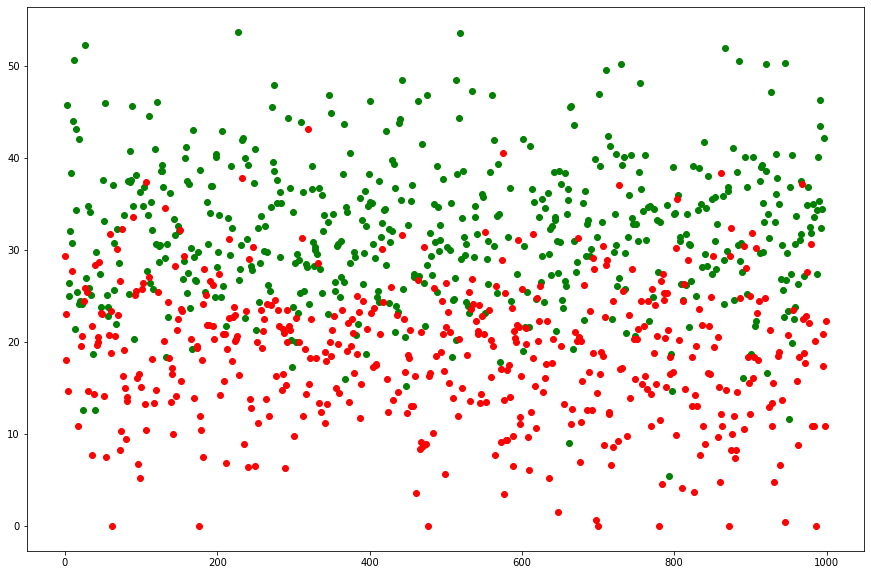

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

accepted_records = data.loc[data.ACCEPTED == 1, ['PAY']]
rejected_records = data.loc[data.ACCEPTED == 0, ['PAY']]
plt.scatter(accepted_records.index, accepted_records, c='g')
plt.scatter(rejected_records.index, rejected_records, c='r')

#### Given that we have to charge riders $30, we want to pay the drivers less than $30 to make a profit. Lets take a look at this data

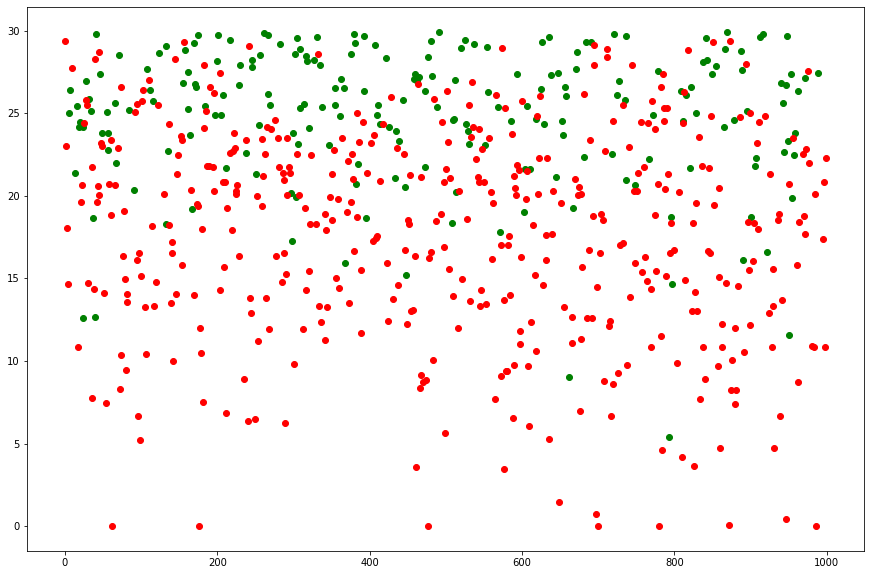

In [5]:
accepted_records_leq30 = data.loc[(data.ACCEPTED == 1) & (data.PAY <= 30), ['PAY']]
rejected_records_leq30 = data.loc[(data.ACCEPTED == 0) & (data.PAY <= 30), ['PAY']]
plt.scatter(accepted_records_leq30.index, accepted_records_leq30, c='g')
plt.scatter(rejected_records_leq30.index, rejected_records_leq30, c='r')

#### Given the data, the two classes cannot be perfectly separated, so the probability of accepting a ride is always <1 (for prices <= 30)

#### We build a model to get the probability of acceptance of a ride based on the data we have

In [6]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

data_u30 = data.loc[data.PAY <= 30]
X_train, X_test, y_train, y_test = train_test_split(data_u30[['PAY']], data_u30['ACCEPTED'], test_size=.25, random_state=0)
model = LogisticRegression(solver='liblinear', random_state=0) 
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7560975609756098

In [7]:
# fit the model on the whole data
model.fit(data_u30[['PAY']], data_u30['ACCEPTED'])

model.predict_proba([[29]])

array([[0.29226803, 0.70773197]])

In [8]:
price_range = [ round(i, 1) for i in np.arange(.1, 30, .1) ]

probs = model.predict_proba(np.array(price_range).reshape(-1, 1))[:, 1]
price_acceptance_probs =  dict(zip(price_range, probs))
expected_profits= {}
for offered_price_to_drivers in price_range:
  acceptance_probability = price_acceptance_probs[offered_price_to_drivers]
  expected_profits[offered_price_to_drivers] = round((30 - offered_price_to_drivers) * acceptance_probability, 4)

Text(0, 0.5, 'expected profit (based on the similar dataset)')

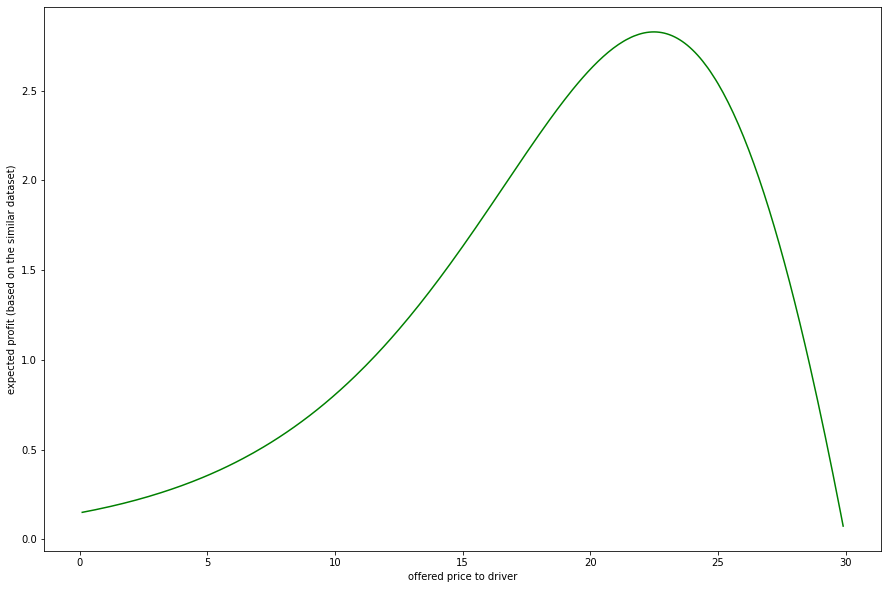

In [9]:
plt.plot(price_range, expected_profits.values(), 'g-')
plt.xlabel('offered price to driver')
plt.ylabel('expected profit (based on the similar dataset)')

#### The highest expected profit (short-term) is $2.828 when $22.5 is offered to the drivers (we would make $2.828 on average, because some of the offers at this price would be rejected)

In [19]:
best_short_term_expected_profit = max(expected_profits.values())
best_short_term_price = [ (key, value) for key,value in expected_profits.items() if value == best_short_term_expected_profit ][0][0]
print(best_short_term_price, best_short_term_expected_profit)

22.5 2.8272


#### We use Probabilistic Dynamic Programming to find the policy that produces the highest long-term expected profit
#### We calculate the optimal policy by going backward from month 12 to month 1
#### For simplicity we use the same price for offers to drivers related to requests of a rider in a month. For example if a rider makes 3 requests in month m, then the price offered to drivers for these three requests are the same. 

In [ ]:
f = {}
policy = {}
max_k = 40
# In month 12, since there is no more months, the price with highest expected immediate profit should be offered to drivers ($22.5)
for k in range(1, max_k + 1):
  f[12, k] = k * price_acceptance_probs[best_short_term_price] * (30 - best_short_term_price)
  policy[12, k] = best_short_term_price

for m in tqdm(range(11, 0, -1)):
  for k in range(1, max_k + 1):
    d = { p:  np.sum([  binom.pmf(i, k, price_acceptance_probs[p]) * i * (30 - p) for i in range(1, k+1) ])  # profit at stage m
              +  np.sum([ binom.pmf(i, k, price_acceptance_probs[p]) * poisson.pmf(k=k_prime, mu=i) * f[m+1, k_prime] for k_prime in range(1,max_k + 1) for i in range(1, k+1) ])  # profit at stage m+1
          for p in [ round(i, 1) for i in np.arange(20, 30, .1) ]
        }
    f[m, k] = max(d.values())
    best_p = [ key for key,value in d.items() if value == f[m, k] ][0]
    policy[m, k] = best_p

#### Expected long-term profit for a rider "acquired" in the first month (Lambda=1)

In [68]:
np.sum([ poisson.pmf(k=i[1], mu=1) * j for i,j in f.items() if i[0] == 1 ])

5.1664177236071245

#### Given that we have to pay $30 for 'acquisition' of each rider, and our expected long-term profit is $5.16, we are going to lose money. We should find a better dataset (where accept/decline is not so mixed) so we can more confidently decide whether a ride would be accepted or not. This results in better long-term expected profit

In [69]:
[ (i,j) for i,j in f.items() if i[1] == 1 ]

[((12, 1), 2.827201239254721),
 ((11, 1), 4.012895175982891),
 ((10, 1), 4.579459214370857),
 ((9, 1), 4.863817740567547),
 ((8, 1), 5.0096706112244895),
 ((7, 1), 5.085279946924755),
 ((6, 1), 5.124738517850218),
 ((5, 1), 5.145403727162326),
 ((4, 1), 5.156226493063286),
 ((3, 1), 5.161894582845382),
 ((2, 1), 5.164863070020642),
 ((1, 1), 5.166417723607379)]

In [66]:
f

{(12, 1): 2.827201239254721,
 (12, 2): 5.654402478509442,
 (12, 3): 8.481603717764163,
 (12, 4): 11.308804957018884,
 (12, 5): 14.136006196273605,
 (12, 6): 16.963207435528325,
 (12, 7): 19.790408674783045,
 (12, 8): 22.617609914037768,
 (12, 9): 25.44481115329249,
 (12, 10): 28.27201239254721,
 (12, 11): 31.099213631801934,
 (12, 12): 33.92641487105665,
 (12, 13): 36.75361611031137,
 (12, 14): 39.58081734956609,
 (12, 15): 42.408018588820816,
 (12, 16): 45.235219828075536,
 (12, 17): 48.062421067330256,
 (12, 18): 50.88962230658498,
 (12, 19): 53.7168235458397,
 (12, 20): 56.54402478509442,
 (12, 21): 59.37122602434914,
 (12, 22): 62.19842726360387,
 (12, 23): 65.02562850285858,
 (12, 24): 67.8528297421133,
 (12, 25): 70.68003098136802,
 (12, 26): 73.50723222062274,
 (12, 27): 76.33443345987747,
 (12, 28): 79.16163469913218,
 (12, 29): 81.98883593838691,
 (12, 30): 84.81603717764163,
 (12, 31): 87.64323841689635,
 (12, 32): 90.47043965615107,
 (12, 33): 93.29764089540579,
 (12, 34): 9

In [67]:
policy

{(12, 1): 22.5,
 (12, 2): 22.5,
 (12, 3): 22.5,
 (12, 4): 22.5,
 (12, 5): 22.5,
 (12, 6): 22.5,
 (12, 7): 22.5,
 (12, 8): 22.5,
 (12, 9): 22.5,
 (12, 10): 22.5,
 (12, 11): 22.5,
 (12, 12): 22.5,
 (12, 13): 22.5,
 (12, 14): 22.5,
 (12, 15): 22.5,
 (12, 16): 22.5,
 (12, 17): 22.5,
 (12, 18): 22.5,
 (12, 19): 22.5,
 (12, 20): 22.5,
 (12, 21): 22.5,
 (12, 22): 22.5,
 (12, 23): 22.5,
 (12, 24): 22.5,
 (12, 25): 22.5,
 (12, 26): 22.5,
 (12, 27): 22.5,
 (12, 28): 22.5,
 (12, 29): 22.5,
 (12, 30): 22.5,
 (12, 31): 22.5,
 (12, 32): 22.5,
 (12, 33): 22.5,
 (12, 34): 22.5,
 (12, 35): 22.5,
 (12, 36): 22.5,
 (12, 37): 22.5,
 (12, 38): 22.5,
 (12, 39): 22.5,
 (12, 40): 22.5,
 (11, 1): 24.1,
 (11, 2): 24.1,
 (11, 3): 24.1,
 (11, 4): 24.1,
 (11, 5): 24.1,
 (11, 6): 24.1,
 (11, 7): 24.1,
 (11, 8): 24.1,
 (11, 9): 24.1,
 (11, 10): 24.1,
 (11, 11): 24.1,
 (11, 12): 24.1,
 (11, 13): 24.1,
 (11, 14): 24.1,
 (11, 15): 24.1,
 (11, 16): 24.1,
 (11, 17): 24.1,
 (11, 18): 24.1,
 (11, 19): 24.1,
 (11, 20): 24.1